In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import xgboost as xgb
import joblib

In [2]:
# Load dataset
df = pd.read_csv('health_emergencies.csv')
df.columns = [c.strip() for c in df.columns]

In [3]:
df.head()

Date  Year   Time Day_of_Week                 Barangay   Latitude  \
0  23/11/2025  2025  13:14    Thursday         San Mateo (Imok)  14.089903   
1  07/05/2022  2022  13:58     Tuesday                      V-C  14.106827   
2  30/09/2024  2024  15:47      Monday                      V-B  14.080581   
3  07/10/2021  2021  12:03      Sunday             San Gregorio  14.031415   
4  11/10/2025  2025  20:19      Sunday  San Antonio 1 (Balanga)  14.012716   

    Longitude Weather        Health_Type     Health_Cause Severity  \
0  121.333461   Foggy  Allergic Reaction        Infection     High   
1  121.282542  Stormy               Fall  Chronic Illness      Low   
2  121.274854   Rainy               Burn         Accident   Medium   
3  121.299749   Sunny               Burn            Other   Medium   
4  121.348980   Sunny  Allergic Reaction          Allergy     High   

   Patient_Count  Response_Time  Treatment_Time  
0              3             12              43  
1              3             12              39  
2              2             20              28  
3              1              9              13  
4              1             14              27

In [4]:
df.shape

(1500, 14)

In [5]:
df.columns

Index(['Date', 'Year', 'Time', 'Day_of_Week', 'Barangay', 'Latitude',
       'Longitude', 'Weather', 'Health_Type', 'Health_Cause', 'Severity',
       'Patient_Count', 'Response_Time', 'Treatment_Time'],
      dtype='object')

In [6]:
df = df[(df['Health_Type'] == 'Giving Birth') & (df['Health_Cause'] == 'Pregnant')]
print(f"Filtered dataset size: {len(df)} rows")

Filtered dataset size: 104 rows


In [7]:
# Handle missing values
df = df.dropna(subset=['Year', 'Barangay', 'Severity'])

In [8]:
# Define features and target
X = df[['Year', 'Barangay']]
y = df['Severity'].apply(lambda x: 1 if x in ['Medium', 'High'] else 0)  # 1 for severe, 0 for low

In [9]:
# Check if dataset is empty
if len(df) == 0:
    print("Error: No data available after filtering. Check health_emergencies.csv.")
    exit()

In [10]:
# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['Year']),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), ['Barangay'])
    ]
)

In [21]:
# XGBoost pipeline
pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', xgb.XGBClassifier(n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42))
])

In [22]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [23]:
# Train model
pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Year']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['Barangay'])])),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rou...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=6, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=100, n_jobs=None,
                               num_parallel_tree=None, ...))])

In [24]:
# Make predictions
y_pred = pipe.predict(X_test)
print("=== Logistic Regression - Classification Report ===")
print(classification_report(y_test, y_pred, digits=4))

=== Logistic Regression - Classification Report ===
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000        14
           1     0.5625    1.0000    0.7200        18

    accuracy                         0.5625        32
   macro avg     0.2812    0.5000    0.3600        32
weighted avg     0.3164    0.5625    0.4050        32



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


=== Logistic Regression - Confusion Matrix ===
[[ 0 14]
 [ 0 18]]


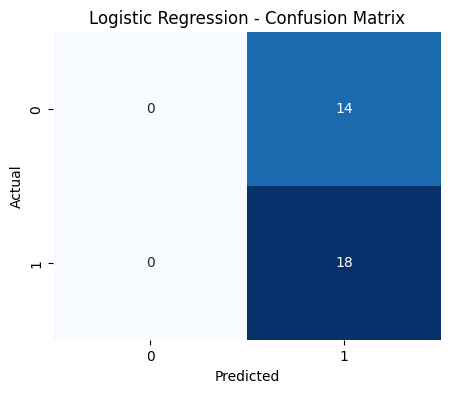

In [25]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("=== Logistic Regression - Confusion Matrix ===")
print(cm)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Logistic Regression - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

=== Logistic Regression - ROC AUC: 0.3909 ===


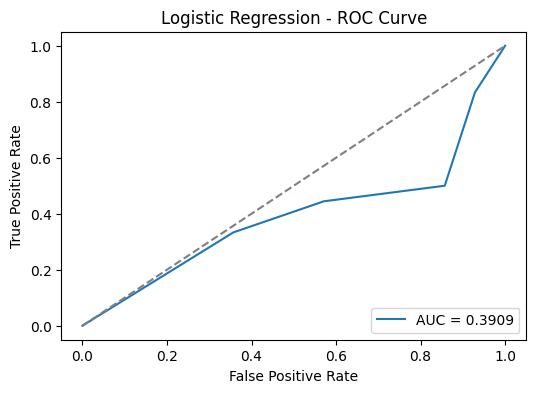

In [26]:
# ROC Curve
y_proba = pipe.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
print(f"=== Logistic Regression - ROC AUC: {roc_auc:.4f} ===")
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Logistic Regression - ROC Curve")
plt.legend(loc='lower right')
plt.show()

In [27]:
# Save model
joblib.dump(pipe, "birth_predictor_xgb.pkl")
print("Saved model to birth_predictor_xbg.pkl")

Saved model to birth_predictor_xbg.pkl
